## Accelerating Metal-Organic Framework Discovery via Synthesisability Prediction: The MFD Evaluation Method for One-Class Classification Models

Chi Zhang, Dmytro Antypov, Matthew J. Rosseinsky, and Matthew S. Dyer*<br/>
Email: M.S.Dyer@liverpool.ac.uk <br/>

Please cite the corresponding paper if you used the Maximum Fractional Differe (MFD) method or these trained machine learning (ML) models in your work.<br/>

The Jupyter Notebook hereafter presents the results of UMAP projection of the query dataset, corresponding to Figure 6 in the paper.

This notebook requires the following input files:

`unlabelled_df.csv` - the query dataset along with 6 elemental metal features and 50 best linker features for porosity prediction [Pétuya, 2022](DOI: 10.1002/anie.202114573)<br/>
`embedding.csv` - the UMAP embedding for `unlabelled_df.csv`<br/>

In [1]:
#import libraries
import sys
import time
from csv import DictWriter

print("Tested and working with:")

import networkx
print(f'networkx: {networkx.__version__}')

import numpy
print(f'numpy: {numpy.__version__}')

import matplotlib
from matplotlib import pyplot as plt

import mordred
from mordred import Calculator, descriptors
print(f'mordred: {mordred.__version__}')

import pandas
print(f'pandas: {pandas.__version__}')

import plotly
import plotly.graph_objs as go
import plotly.io as pio
print(f'plotly: {plotly.__version__}')

import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors
print(f'rdkit: {rdkit.__version__}')

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import f_classif, SelectKBest, VarianceThreshold
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
print(f'sklearn: {sklearn.__version__}')

Tested and working with:
networkx: 2.1
numpy: 1.21.5
mordred: 1.2.0
pandas: 1.2.5
plotly: 5.15.0
rdkit: 2021.03.5
sklearn: 0.24.2


Reading 1M1L3D dataset

In [2]:
#import the query dataset
unlabelled_pairs = pandas.read_csv('dataset_generation_and_featurization/query_pairs.csv', index_col=0)
unlabelled_pairs

metal                                      linker_SMILES
0         Co                                 c1cc(C2=NNNN2)ccn1
1         Co                   c1cncc(-c2cc(-c3cccnc3)[nH]n2)c1
2         Co  Cc1cc(C)c(-c2cc(C(=O)O)cc(C(=O)O)c2)cc1-c1cc(C...
3         Co                OC(O)c1ccc(-n2cnc3cc4ccccc4cc32)cc1
4         Co                     O=C1O[C@H]([C@H](O)CO)C(O)=C1O
...      ...                                                ...
160577     W                   c1cncc(-c2n[nH]c(-c3ccncc3)n2)c1
160578     W            O=C(O)C1=NC(c2cccc(Cl)c2)=N[C@H]1C(=O)O
160579     W           Cc1n[nH]c(C)c1-c1ccc(-c2c(C)n[nH]c2C)cc1
160580     W  Cc1cc(C)c(-c2c3nc(c(-c4ccc(C(=O)O)cc4)c4ccc([n...
160581     W   c1c2[nH][nH][nH]c2cc2oc3cc4[nH][nH][nH]c4cc3oc12

[160582 rows x 2 columns]

In [3]:
#import the results of porosity predictions and synthesisablity predictions using the best-performing DeepSVDD model
prediction_pd = pandas.read_csv('combination_prediction_final.csv',index_col=0)
prediction = prediction_pd.loc[:,'porosity']
deepsvdd_result_scaled = prediction_pd.loc[:,'deepsvdd']
deepsvdd_predict = prediction_pd['deepsvdd_predict']

In [25]:
# Visualization with UMAP
import seaborn as sns
import umap as umap
reducer = umap.UMAP(random_state=42, n_neighbors= 80)
embedding = reducer.fit_transform(unlabelled_df.iloc[:,2:]) 
'''
from scipy.spatial.distance import pdist, squareform
dist_mat = squareform(pdist(unlabelled_df.iloc[:,2:]))

# Check how much of the distance is preserved on the data
from scipy.spatial.distance import squareform, pdist
dist_mat_umap = squareform(pdist(embedding))
pearson = np.corrcoef(dist_mat.flatten() ,dist_mat_umap.flatten())
print(pearson[1,0])
'''

'\nfrom scipy.spatial.distance import pdist, squareform\ndist_mat = squareform(pdist(unlabelled_df.iloc[:,2:]))\n\n# Check how much of the distance is preserved on the data\nfrom scipy.spatial.distance import squareform, pdist\ndist_mat_umap = squareform(pdist(embedding))\npearson = np.corrcoef(dist_mat.flatten() ,dist_mat_umap.flatten())\nprint(pearson[1,0])\n'

In [56]:
embedding_pd = pd.DataFrame({'0': embedding[:, 0], '1': embedding[:, 1]})
embedding_pd.to_csv('embedding.csv')

In [4]:
import pandas as pd
embedding_pd = pd.read_csv('embedding.csv', index_col=0)
embedding = embedding_pd.to_numpy()

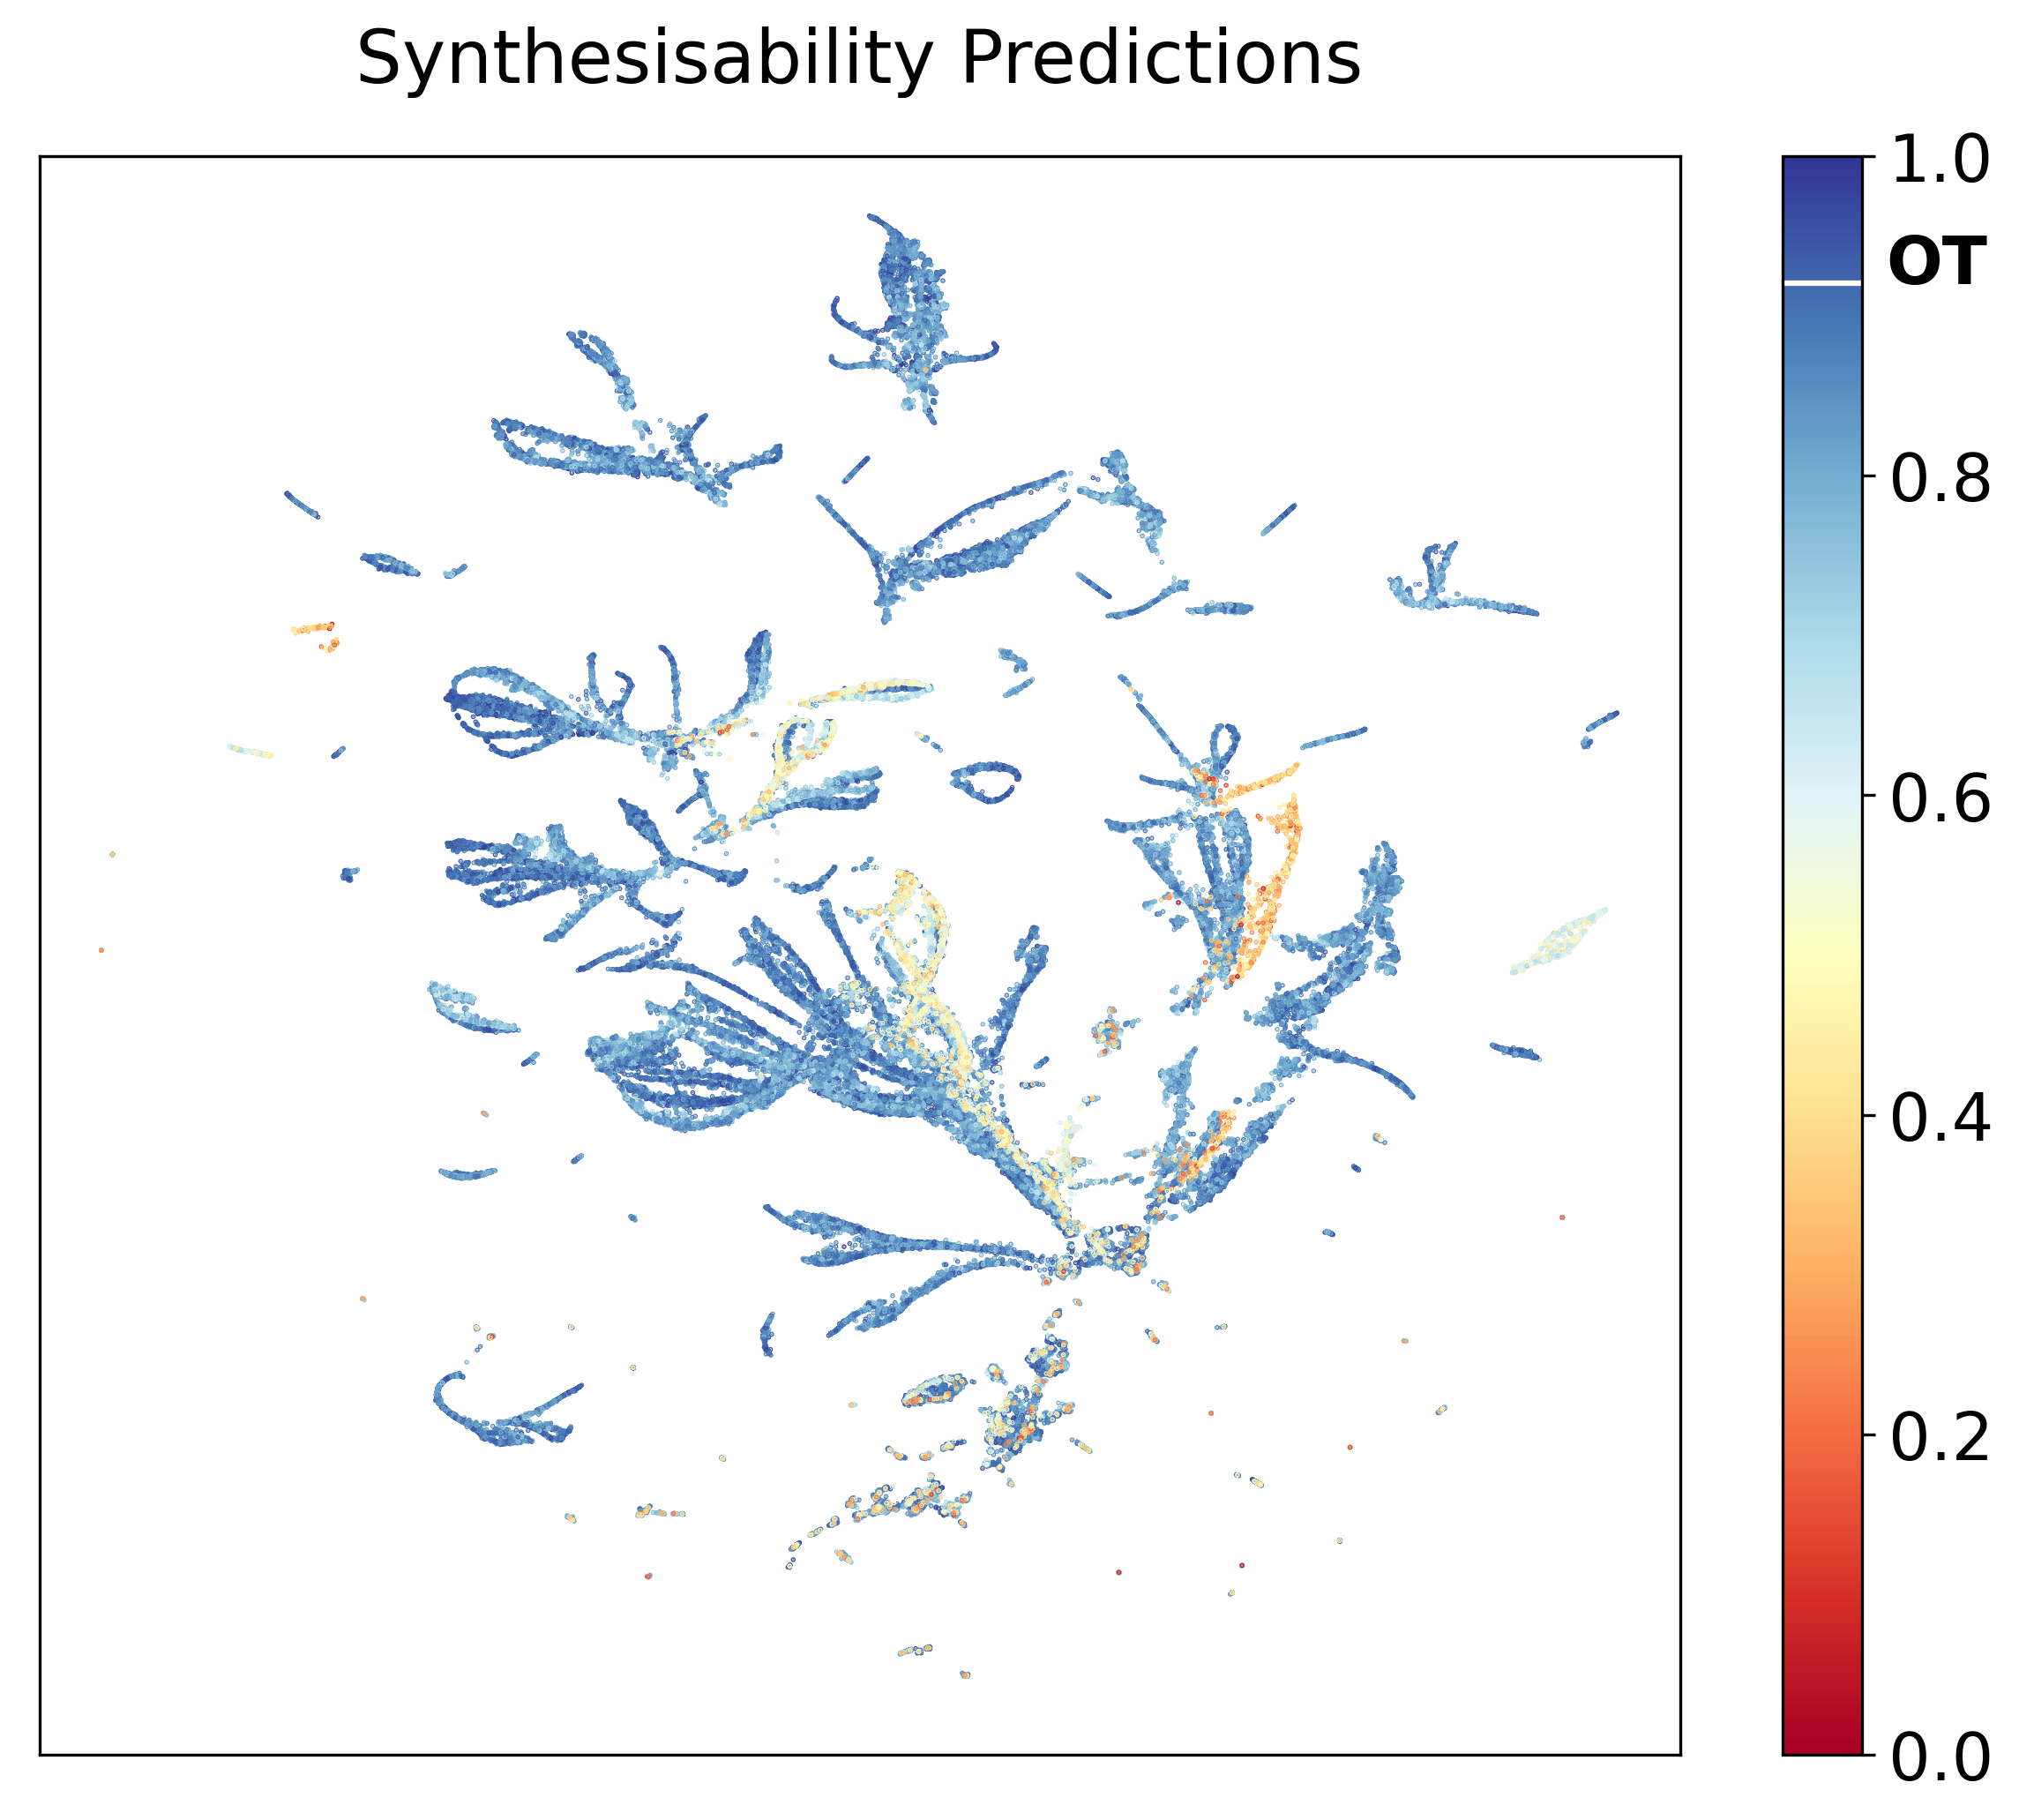

In [13]:
fig, ax = plt.subplots(figsize=(10,8), dpi=300)
cm = plt.cm.get_cmap('RdYlBu')
s = ax.scatter(embedding[:, 0], embedding[:, 1],c=deepsvdd_result_scaled, alpha=1, s=0.1,cmap=cm, vmin=0, vmax=1) 
plt.title('Synthesisability Predictions', fontsize=20, pad=20);
#plt.xlabel('UMAP_1', fontsize=18)
#plt.ylabel('UMAP_2', fontsize=18)
plt.yticks([])
plt.xticks([])
plt.xlim(-7,25)
plt.ylim(-16,25)
cbar = plt.colorbar(s)
cbar.ax.tick_params(labelsize=18)
cbar.ax.axhline(0.92, c='w')
cbar.ax.text(1.3, 0.92, 'OT', fontsize=18, fontweight='semibold')
plt.show()

In [6]:
#select embeddings of datapoints with true synthesisability predictions
embedding_true = embedding[deepsvdd_predict==1,:]

#select embeddings of datapoints with false synthesisability predictions
embedding_false = embedding[deepsvdd_predict==0,:]

#select the porosity predictions of datapoints with true synthesisability predictions
prediction_true = prediction[deepsvdd_predict==1]

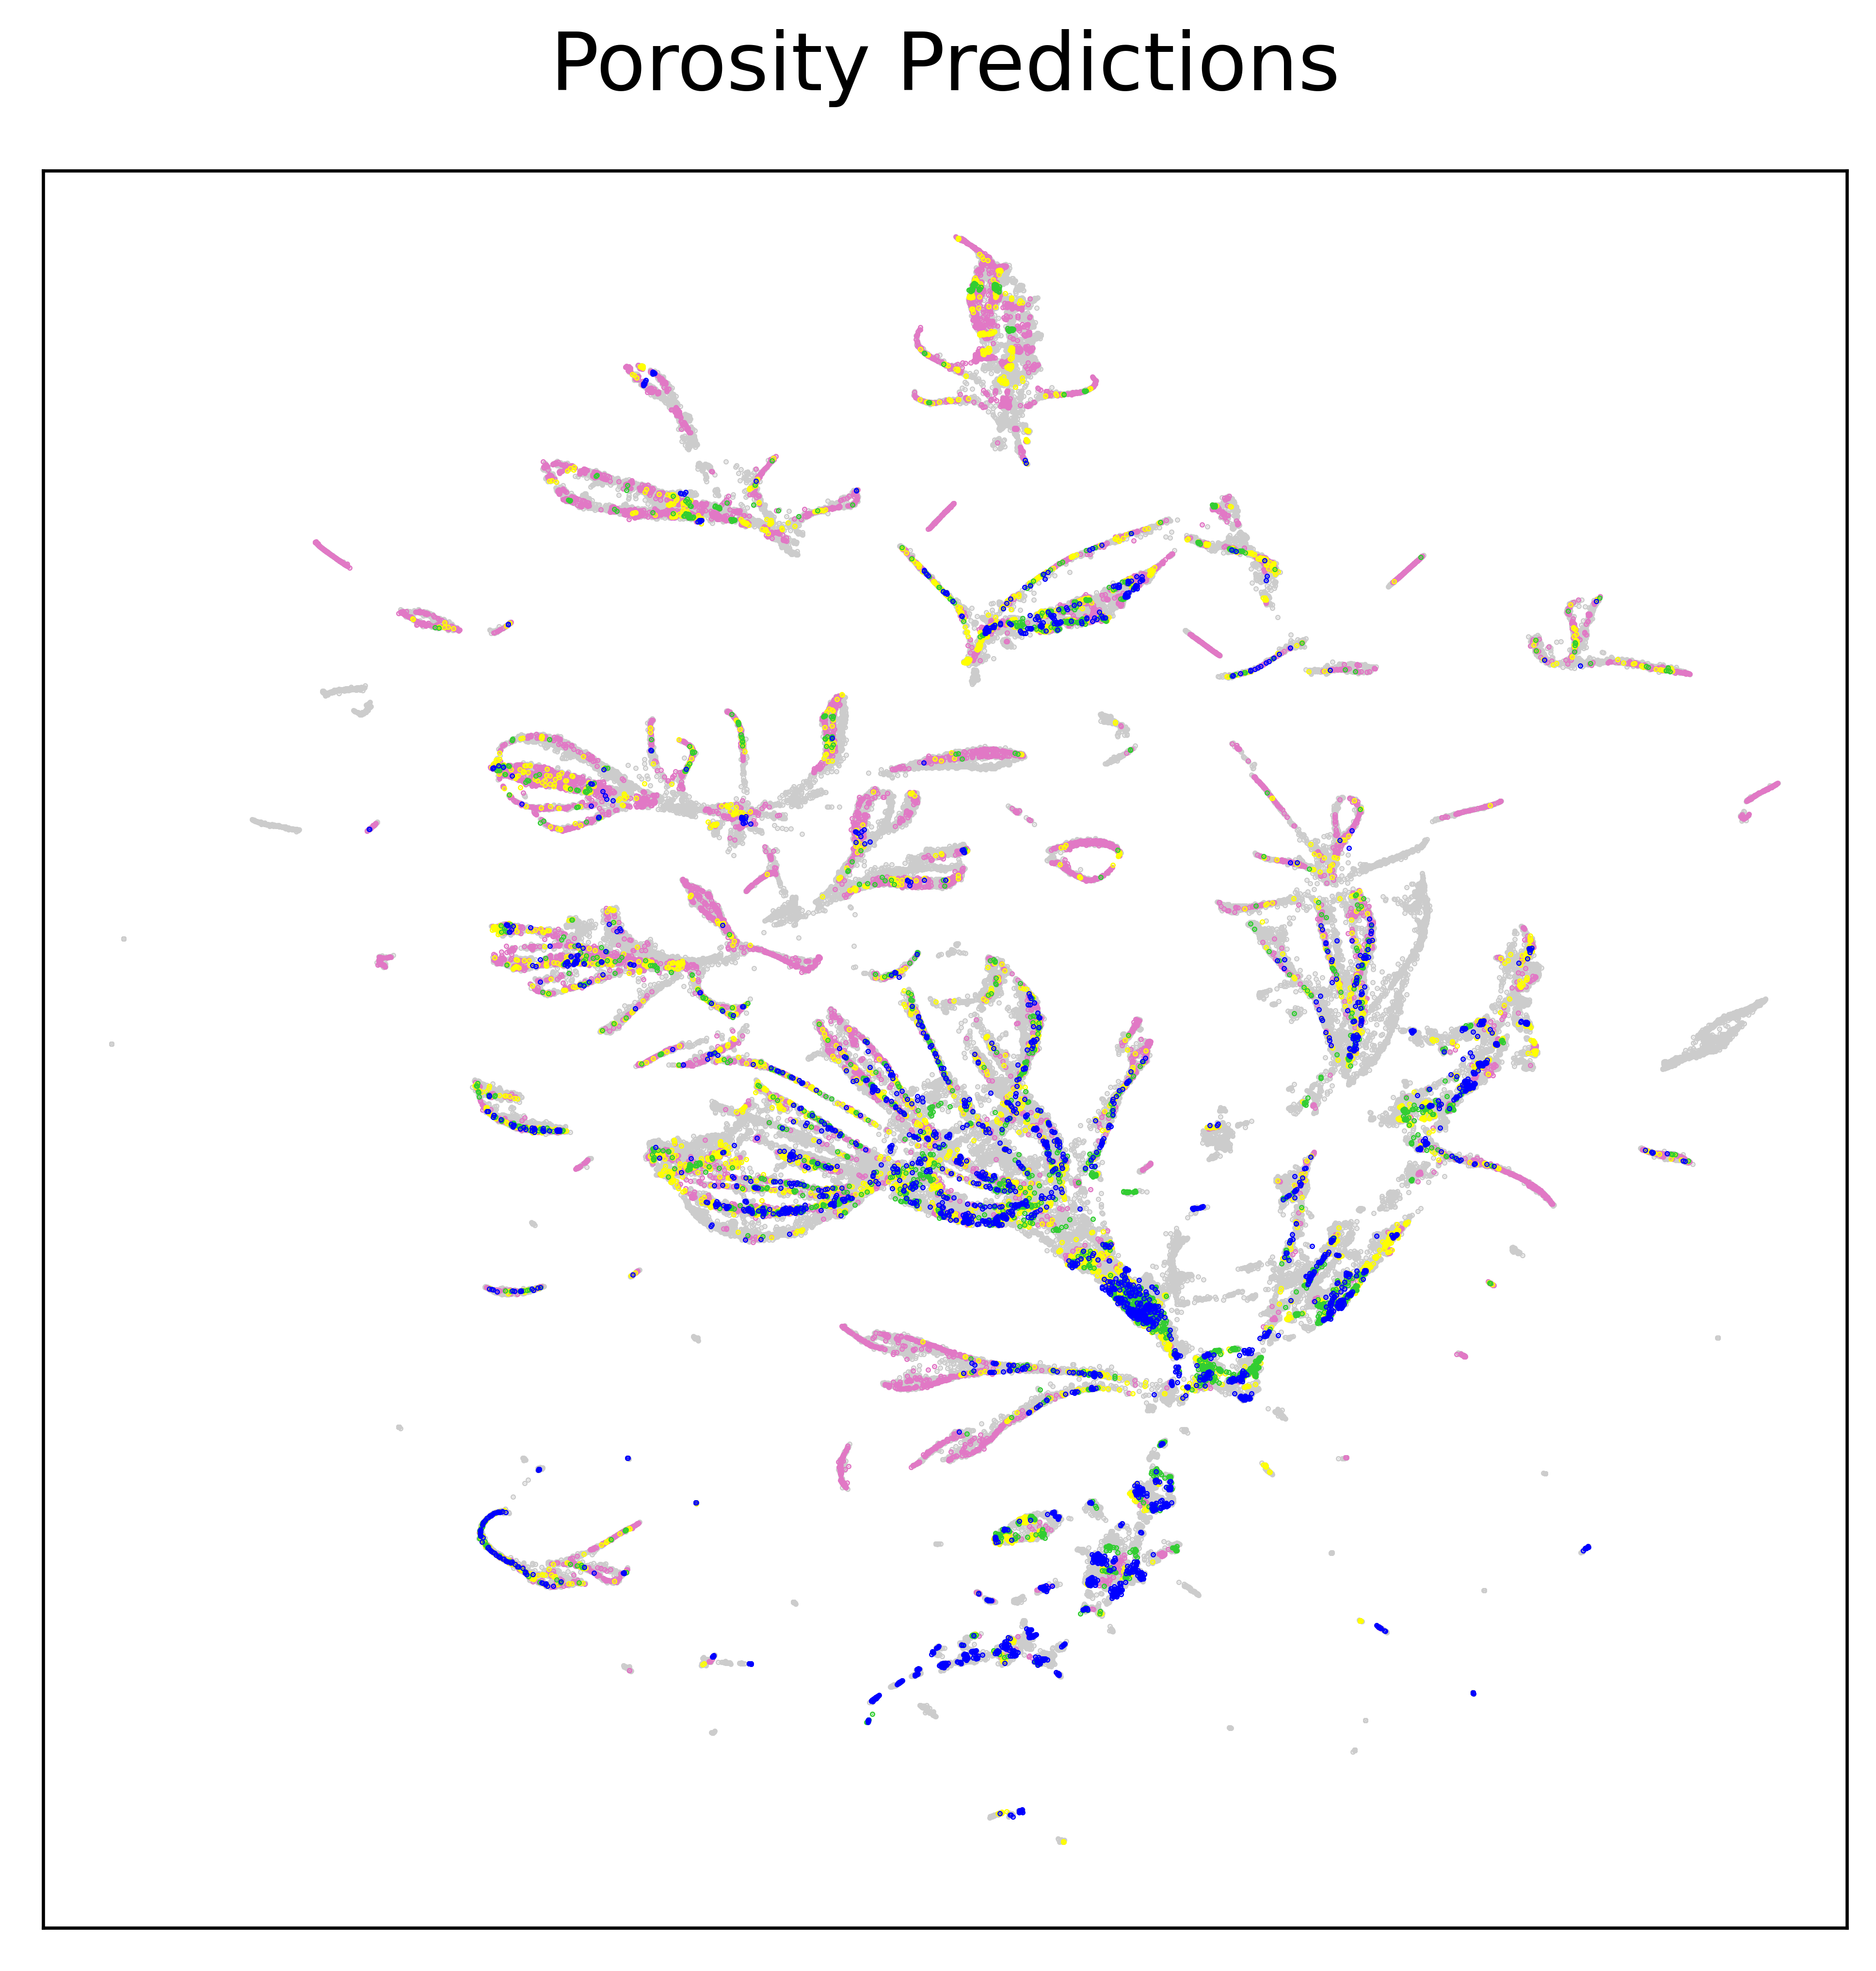

In [10]:
fig, ax = plt.subplots(figsize=(8,8), dpi=600)
cm = {0:'#CCCCCC',1:'yellow',2:'limegreen',3:'blue'}

#using grey dots to show datapoints with synthesisability prediction scores below OT 
ax.scatter(embedding_false[:, 0], embedding_false[:, 1],c='#CCCCCC', alpha=1, s=0.1) 
#using colored dots to datapoints with synthesisability prediction scores above OT
ax.scatter(embedding_true[prediction_true==0, 0], embedding_true[prediction_true==0, 1],c='#E178C5', alpha=1, s=0.1) 
ax.scatter(embedding_true[prediction_true==1, 0], embedding_true[prediction_true==1, 1],c='yellow', alpha=1, s=0.1) 
ax.scatter(embedding_true[prediction_true==2, 0], embedding_true[prediction_true==2, 1],c='limegreen', alpha=1, s=0.1) 
ax.scatter(embedding_true[prediction_true==3, 0], embedding_true[prediction_true==3, 1],c='blue', alpha=1, s=0.1) 

plt.title('Porosity Predictions', fontsize=20, pad=20);
plt.xlim(-7,25)
plt.ylim(-16,25)

plt.yticks([])
plt.xticks([])
plt.show()

# Cluster Analysis 

## Cluster I: Ba 

In [137]:
cluster_1 = np.where((embedding[:,0]<8) & (embedding[:,0]>5) & (embedding[:,1]<-4) & (embedding[:,1]>-6))
len(cluster_1[0])

539

In [138]:
cluster_1_combination = prediction_pd.iloc[cluster_1[0],:]
cluster_1_combination = cluster_1_combination.loc[cluster_1_combination['deepsvdd_predict']==1]
cluster_1_combination

metal                          linker_SMILES  deepsvdd  porosity  \
107309    Ba                O=C(O)c1cccc(C(=O)O)c1O  0.950101         0   
107319    Ba                    O=C(O)/C=C/c1ccncc1  0.943957         0   
107330    Ba                 O=C(O)c1cccc(C(=O)O)c1  0.981478         0   
107332    Ba                O=C(O)c1cc(O)c(O)c(O)c1  0.952334         0   
107415    Ba             O=C(O)CCc1ccc(OCC(=O)O)cc1  0.920886         0   
...      ...                                    ...       ...       ...   
110277    Ba                    O=C(O)/C=C/c1cccnc1  0.942783         0   
110279    Ba                O=C(O)c1cc[n+]([O-])cc1  0.971622         0   
110284    Ba  Cc1c(C(=O)O)c(C)c(C(=O)O)c(C)c1C(=O)O  0.926120         0   
110315    Ba    O=C(O)C1=NC(c2ccccn2)=N[C@H]1C(=O)O  0.931994         0   
110317    Ba         O=C(O)COc1ccc(C(=O)O)cc1C(=O)O  0.946419         0   

        deepsvdd_predict  
107309                 1  
107319                 1  
107330                 1  
107332                 1  
107415                 1  
...                  ...  
110277                 1  
110279                 1  
110284                 1  
110315                 1  
110317                 1  

[146 rows x 5 columns]

In [139]:
metal_set_1 = set(cluster_1_combination['metal'].tolist())
len(metal_set_1)

1

In [140]:
linker_set_1 = set(cluster_1_combination['linker_SMILES'].tolist())
len(linker_set_1)

146

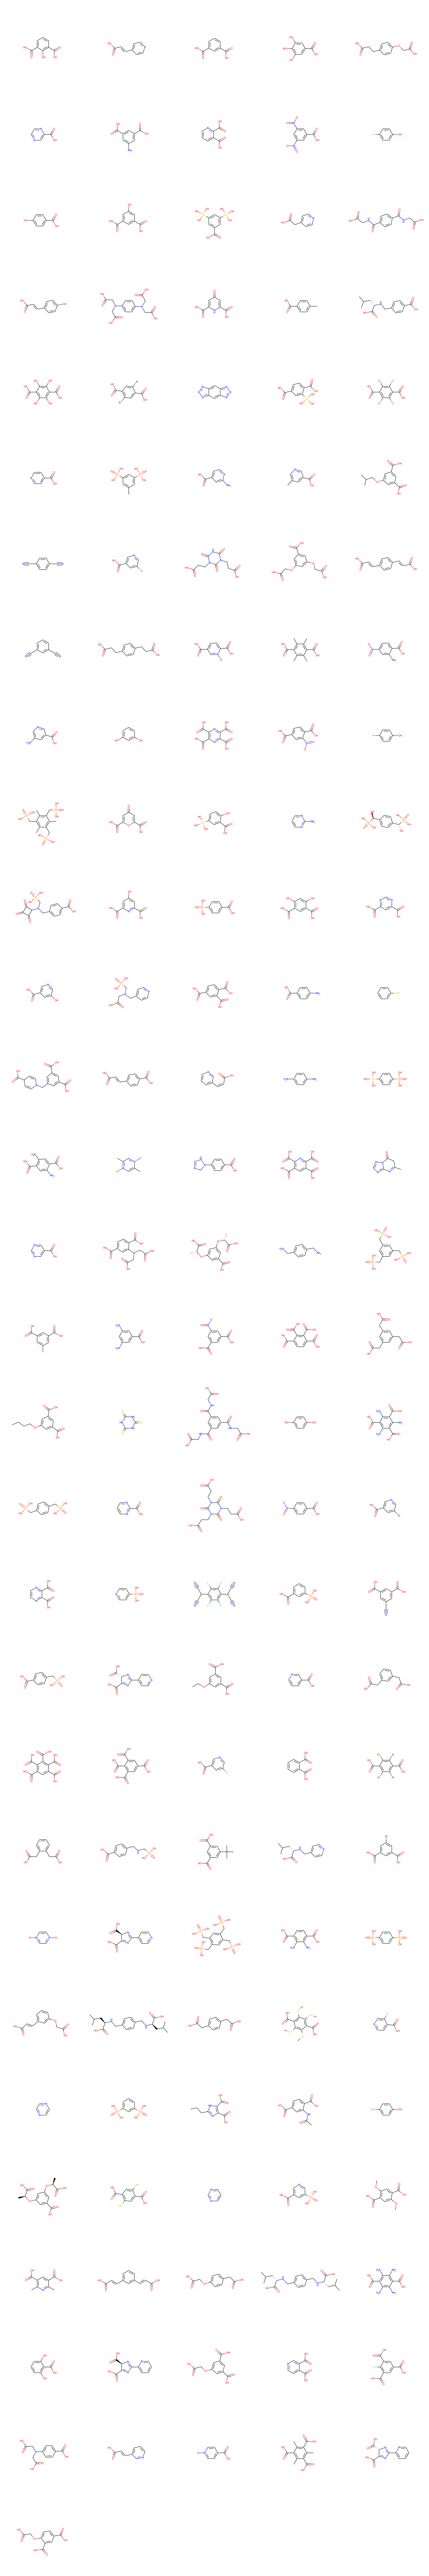

In [34]:
import pandas as pd
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

mols_list = []

for i in cluster_1_combination['linker_SMILES']:
    mols = Chem.MolFromSmiles(i)
    mols_list.append(mols)
    
mols_per_row = len(mols_list)  
Chem.Draw.MolsToGridImage(mols_list, molsPerRow=5, maxMols=200, subImgSize=(500, 500))

## Cluster II: Ba

In [ ]:
cluster_2 = np.where((embedding[:,0]<14) & (embedding[:,0]>13) & (embedding[:,1]<15) & (embedding[:,1]>13.5))
len(cluster_2[0])

In [131]:
cluster_2_combination = prediction_pd.iloc[cluster_2[0],:]
cluster_2_combination = cluster_2_combination.loc[cluster_2_combination['deepsvdd_predict']==1]
cluster_2_combination

metal                             linker_SMILES  deepsvdd  porosity  \
107347    Ba         CC1(C)[C@@H](C(=O)O)[C@@H]1C(=O)O  0.927099         0   
107363    Ba          CC1(C)[C@@H](C(=O)O)[C@H]1C(=O)O  0.927099         0   
107365    Ba                     O=C(O)/C=C\C=C\C(=O)O  0.972239         0   
107397    Ba  O=C(O)C[C@H](C(=O)O)[C@H](CC(=O)O)C(=O)O  0.968485         0   
107422    Ba                                       OCO  0.957985         0   
...      ...                                       ...       ...       ...   
110215    Ba       O[C@@H]1CO[C@@H](O)[C@H](O)[C@@H]1O  0.931534         0   
110244    Ba        [C][C@@H](C[C@H]([C])C(=O)O)C(=O)O  0.922600         0   
110256    Ba                                      N#CS  0.930329         0   
110278    Ba                       N#CC(C#N)=C(C#N)C#N  0.953492         0   
110300    Ba                O=C(O)C1CCN(CP(=O)(O)O)CC1  0.948894         0   

        deepsvdd_predict  
107347                 1  
107363                 1  
107365                 1  
107397                 1  
107422                 1  
...                  ...  
110215                 1  
110244                 1  
110256                 1  
110278                 1  
110300                 1  

[134 rows x 5 columns]

In [132]:
metal_set_2 = set(cluster_2_combination['metal'].tolist())
len(metal_set_2)

1

In [133]:
linker_set_2 = set(cluster_2_combination['linker_SMILES'].tolist())
len(linker_set_2)

134

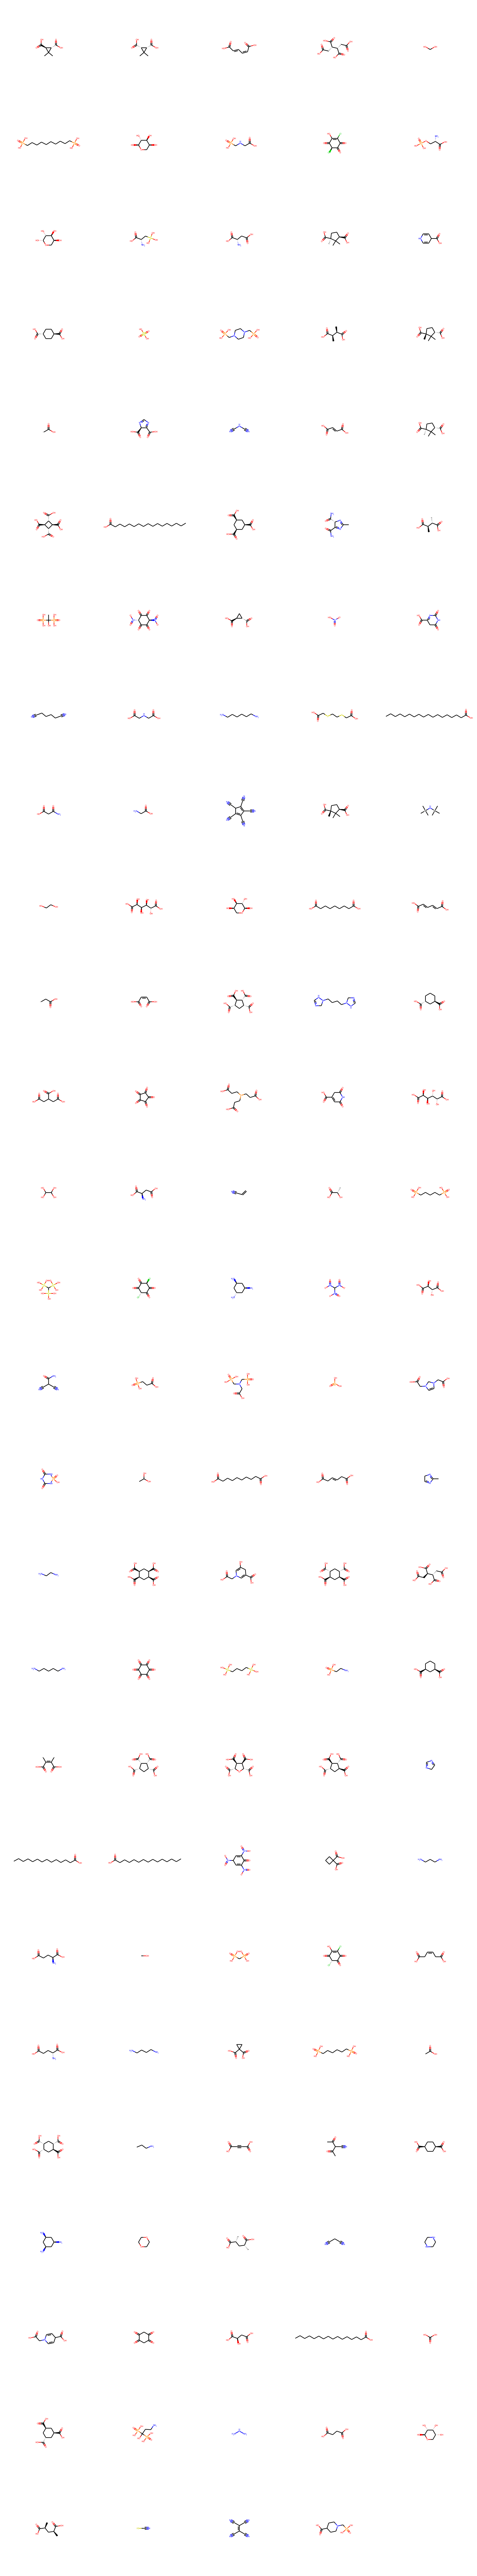

In [50]:
import pandas as pd
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

mols_list = []

for i in cluster_2_combination['linker_SMILES']:
    mols = Chem.MolFromSmiles(i)
    mols_list.append(mols)
    
mols_per_row = len(mols_list)  
Chem.Draw.MolsToGridImage(mols_list, molsPerRow=5, maxMols=150, subImgSize=(300,300))

## Cluster III 

In [5]:
cluster_blue = np.where((embedding[:,0]<14) & (embedding[:,0]>13) & (embedding[:,1]<1) & (embedding[:,1]>0.5))
len(cluster_blue[0])

100

In [6]:
cluster_blue_combination = prediction_pd.iloc[cluster_blue[0],:]
#cluster_4_combination = cluster_4_combination.loc[cluster_4_combination['deepsvdd_predict']==1]
cluster_blue_combination

metal                                      linker_SMILES  deepsvdd  \
1458      Co  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.952221   
2122      Co  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.870746   
4190      Ag  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.948978   
4898      Ag  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.851176   
7673      Mn  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.834105   
...      ...                                                ...       ...   
153594    Cr  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.812062   
155949    Ru  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.600929   
156759    Ru  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.540539   
159118     W  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.383289   
159927     W  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.386578   

        porosity  deepsvdd_predict  
1458           3                 1  
2122           1                 0  
4190           3                 1  
4898           1                 0  
7673           1                 0  
...          ...               ...  
153594         1                 0  
155949         3                 0  
156759         1                 0  
159118         3                 0  
159927         1                 0  

[100 rows x 5 columns]

In [7]:
#combination with the linker & synthesisable
cluster_blue_combination = prediction_pd.iloc[cluster_blue[0],:]
cluster_blue_combination = cluster_blue_combination.loc[cluster_blue_combination['deepsvdd_predict']==1]
cluster_blue_combination

metal                                      linker_SMILES  deepsvdd  \
1458      Co  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.952221   
4190      Ag  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.948978   
9846      Tb  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.936972   
15149     Fe  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.942647   
17802     Zn  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.957715   
20479     Pb  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.933077   
23475     La  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.946288   
26458     Eu  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.937262   
29475     Er  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.933255   
32508     Ni  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.943906   
47313     Gd  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.922554   
50350     Dy  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.942116   
53392     Sm  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.936305   
65573     Ho  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.928485   
68643     Pr  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.933584   
74840     Li  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.945954   
81052     Ca  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.949335   
84086     Na  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.935050   
90279     Mg  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.933747   
93356     In  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.931431   
99597      Y  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.925590   
102719    Yb  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.928994   
133921    Sr  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.930939   

        porosity  deepsvdd_predict  
1458           3                 1  
4190           3                 1  
9846           3                 1  
15149          3                 1  
17802          3                 1  
20479          3                 1  
23475          3                 1  
26458          3                 1  
29475          3                 1  
32508          3                 1  
47313          3                 1  
50350          3                 1  
53392          3                 1  
65573          3                 1  
68643          3                 1  
74840          3                 1  
81052          3                 1  
84086          3                 1  
90279          3                 1  
93356          3                 1  
99597          3                 1  
102719         3                 1  
133921         3                 1

In [15]:
#combination with the linker & synthesisable
cluster_blue_combination = prediction_pd.iloc[cluster_blue[0],:]
cluster_blue_combination = cluster_blue_combination.loc[cluster_blue_combination['linker_SMILES']=='Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c(C)c(C)c(C(=O)O)c(C)c2C)c1C']
cluster_blue_combination

metal                                      linker_SMILES  deepsvdd  \
2122      Co  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.870746   
4898      Ag  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.851176   
7673      Mn  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.834105   
10607     Tb  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.805831   
13044     Cu  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.858962   
15930     Fe  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.849080   
21244     Pb  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.829521   
24248     La  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.830484   
27212     Eu  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.803009   
30255     Er  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.800859   
33270     Ni  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.844863   
35866     Cd  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.872094   
38873     Sc  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.811116   
41979     Rb  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.794765   
45061     Zr  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.839188   
48077     Gd  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.818785   
51121     Dy  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.797979   
54171     Sm  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.806363   
60280     Nd  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.807588   
63277      K  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.837183   
66358     Ho  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.801299   
69417     Pr  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.824374   
72535     Tm  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.802718   
75632     Li  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.828547   
78765     Ga  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.793476   
81835     Ca  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.842228   
84864     Na  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.818776   
87984     Bi  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.822106   
91071     Mg  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.829411   
94138     In  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.822516   
97276      V  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.728549   
100395     Y  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.810780   
103512    Yb  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.808850   
106653    Hg  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.820144   
109701    Ba  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.836803   
112790     U  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.808225   
115935    Th  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.721517   
119085    Lu  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.752238   
122180    Cs  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.806287   
125326    Mo  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.679410   
128480    Tl  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.770436   
131627    Sn  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.857090   
134706    Sr  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.835353   
137855    Sb  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.676894   
140979    Al  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.823372   
144117    Hf  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.767853   
147280    Be  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.479106   
150435    Ti  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.804421   
153594    Cr  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.812062   
156759    Ru  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.540539   
159927     W  Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c...  0.386578   

  

In [16]:
len(cluster_blue_combination)

51

In [295]:
cluster_blue_combination['linker_SMILES']

{'Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O)c(C)c1C)c1c(C)c(C)c(C(=O)O)c(C)c1C',
 'Cc1cc(C)c(C)c(B(c2c(C)c(C)c(C(=O)O)c(C)c2C)c2c(C)c(C)c(C(=O)O)c(C)c2C)c1C'}

In [17]:
#combination with the linker & synthesisable
cluster_blue_combination = prediction_pd.iloc[cluster_blue[0],:]
cluster_blue_combination = cluster_blue_combination.loc[cluster_blue_combination['linker_SMILES']=='Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O)c(C)c1C)c1c(C)c(C)c(C(=O)O)c(C)c1C']
cluster_blue_combination

metal                                      linker_SMILES  deepsvdd  \
1458      Co  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.952221   
4190      Ag  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.948978   
9846      Tb  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.936972   
15149     Fe  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.942647   
17802     Zn  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.957715   
20479     Pb  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.933077   
23475     La  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.946288   
26458     Eu  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.937262   
29475     Er  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.933255   
32508     Ni  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.943906   
38070     Sc  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.868939   
41189     Rb  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.897375   
44270     Zr  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.917723   
47313     Gd  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.922554   
50350     Dy  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.942116   
53392     Sm  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.936305   
59506     Nd  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.909378   
62507      K  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.906191   
65573     Ho  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.928485   
68643     Pr  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.933584   
71735     Tm  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.875666   
74840     Li  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.945954   
77961     Ga  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.877067   
81052     Ca  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.949335   
84086     Na  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.935050   
87182     Bi  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.906414   
90279     Mg  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.933747   
93356     In  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.931431   
96471      V  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.879738   
99597      Y  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.925590   
102719    Yb  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.928994   
105850    Hg  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.887131   
108925    Ba  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.912326   
111999     U  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.907560   
115128    Th  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.842571   
118279    Lu  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.881008   
121393    Cs  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.914618   
124519    Mo  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.716280   
127674    Tl  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.847170   
130820    Sn  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.894143   
133921    Sr  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.930939   
137047    Sb  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.595014   
140184    Al  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.914524   
143313    Hf  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.867474   
146472    Be  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.561884   
149629    Ti  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.860029   
152785    Cr  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.858126   
155949    Ru  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.600929   
159118     W  Cc1c(C)c(C(=O)O)c(C)c(C)c1B(c1c(C)c(C)c(C(=O)O...  0.383289   

        porosity  deepsvdd_predict  
1458           3                 1  
4190           3                 1  
9846           3                 1  
15149   

In [181]:
metal_set_blue = set(cluster_blue_combination['metal'].tolist())
len(metal_set_blue)

52

In [182]:
linker_set_blue = set(cluster_blue_combination['linker_SMILES'].tolist())
len(linker_set_blue)

2

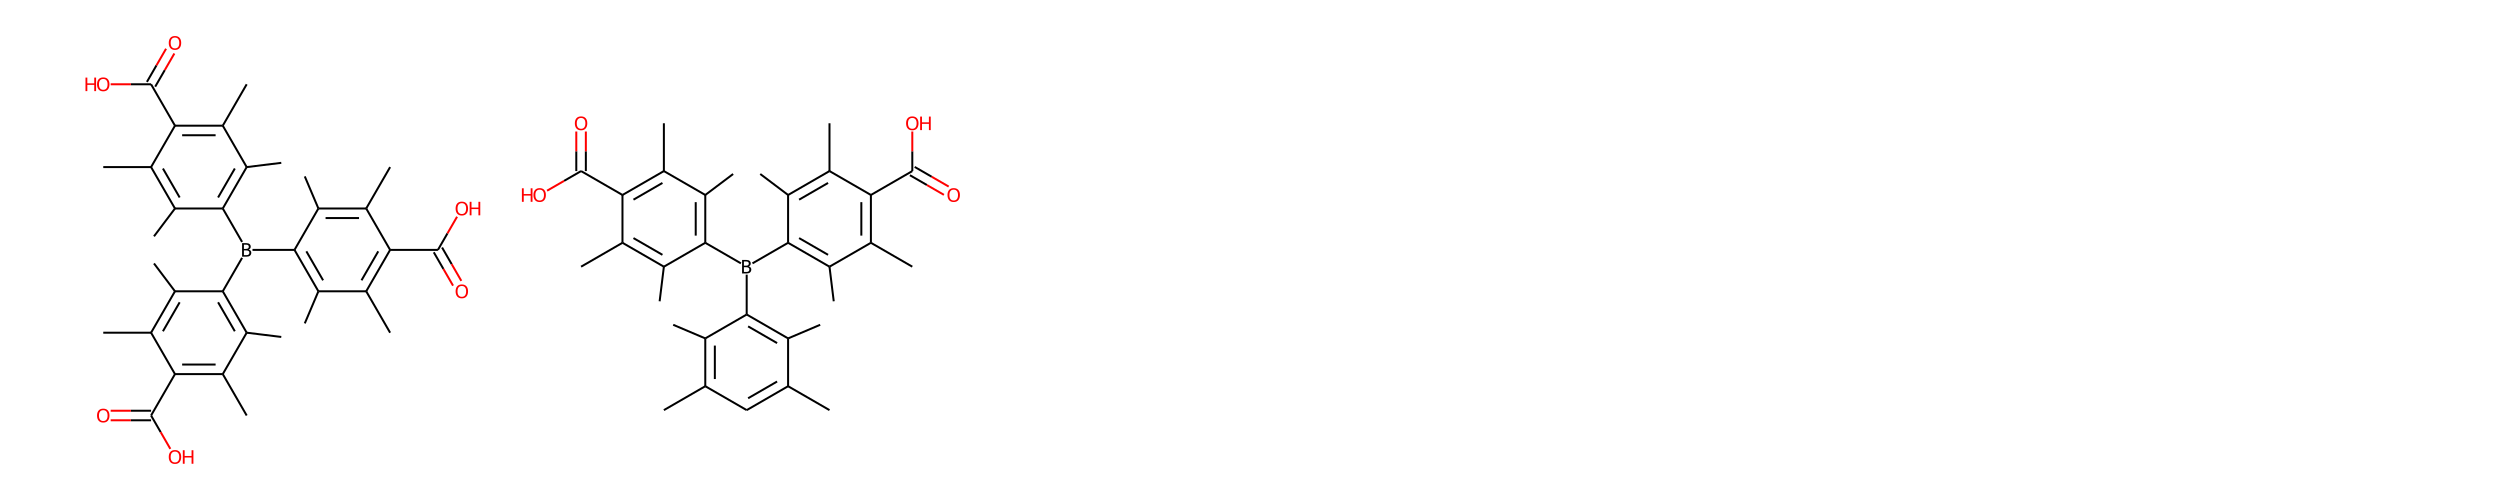

In [311]:
mols_list = []

for i in linker_set_blue:
    mols = Chem.MolFromSmiles(i)
    mols_list.append(mols)
    
mols_per_row = len(mols_list)  
Chem.Draw.MolsToGridImage(mols_list, molsPerRow=5, maxMols=200, subImgSize=(500, 500))

## Cluster IV

In [197]:
cluster_green = np.where((embedding[:,0]<13) & (embedding[:,0]>12) & (embedding[:,1]<1.5) & (embedding[:,1]>1))
len(cluster_green[0])

48

In [198]:
cluster_green_combination = prediction_pd.iloc[cluster_green[0],:]
cluster_green_combination = cluster_green_combination.loc[cluster_green_combination['deepsvdd_predict']==0]
cluster_green_combination

metal                                      linker_SMILES  deepsvdd  \
36727     Sc  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.855628   
39873     Rb  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.892405   
61241      K  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.915391   
70395     Tm  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.896869   
73521     Li  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.909878   
76616     Ga  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.896795   
85841     Bi  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.897104   
95126      V  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.815485   
104505    Hg  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.870425   
110680     U  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.901093   
113786    Th  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.847934   
116936    Lu  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.881921   
123167    Mo  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.806785   
126326    Tl  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.857710   
129478    Sn  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.885511   
135694    Sb  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.695963   
141971    Hf  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.880833   
145118    Be  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.617960   
148282    Ti  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.855881   
151436    Cr  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.851225   
154596    Ru  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.555188   
157763     W  O=C(O)c1c(Cl)c(Cl)c(C(c2c(Cl)c(Cl)c(C(=O)O)c(C...  0.421169   

        porosity  deepsvdd_predict  
36727          2                 0  
39873          2                 0  
61241          2                 0  
70395          2                 0  
73521          2                 0  
76616          2                 0  
85841          2                 0  
95126          2                 0  
104505         2                 0  
110680         2                 0  
113786         2                 0  
116936         2                 0  
123167         2                 0  
126326         2                 0  
129478         2                 0  
135694         2                 0  
141971         2                 0  
145118         2                 0  
148282         2                 0  
151436         2                 0  
154596         2                 0  
157763         2                 0

In [193]:
metal_set_green = set(cluster_green_combination['metal'].tolist())
len(metal_set_green)

48

In [194]:
linker_set_green = set(cluster_green_combination['linker_SMILES'].tolist())
len(linker_set_green)

1

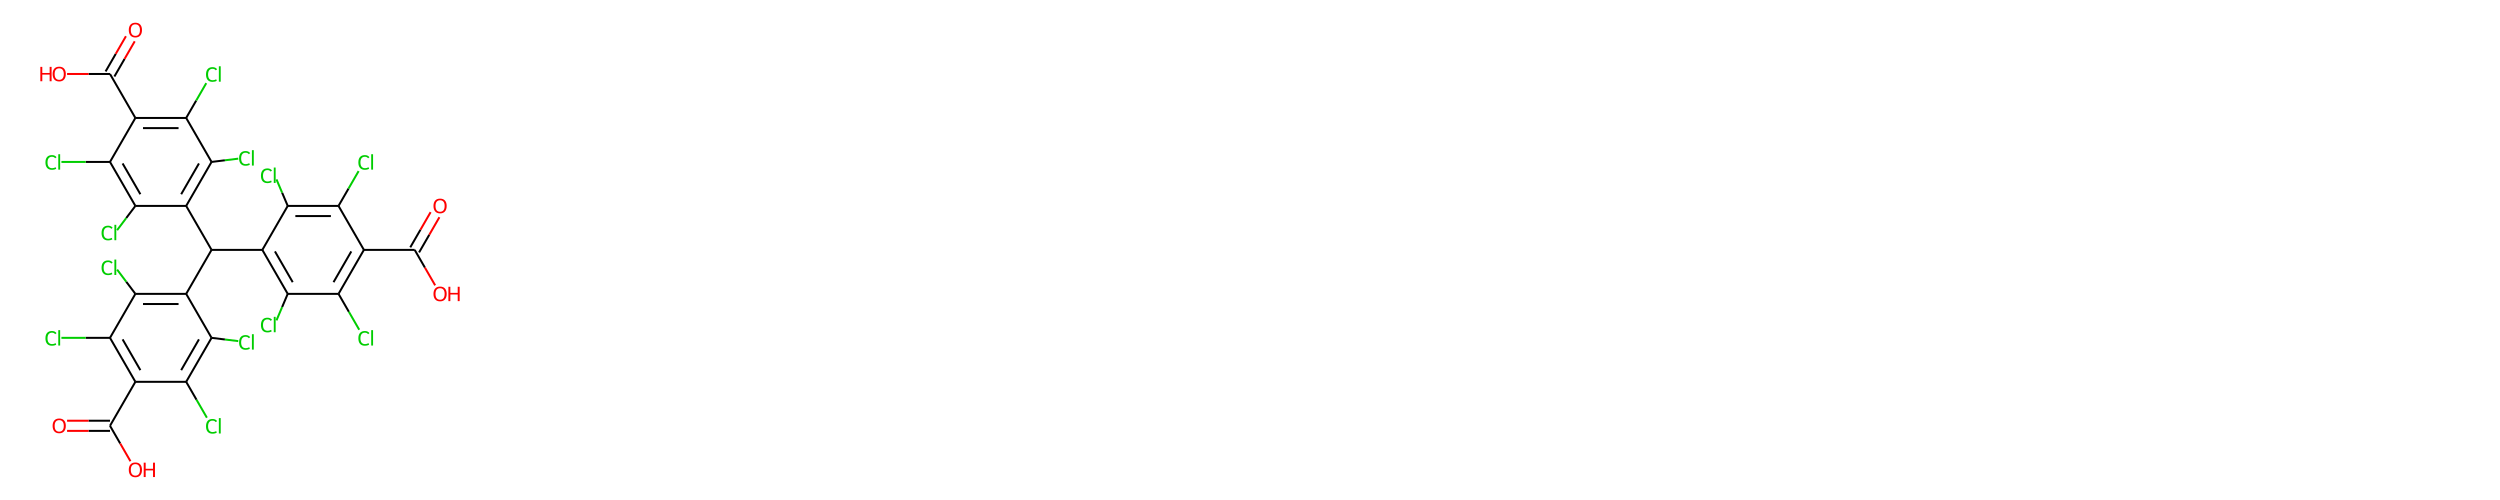

In [178]:
mols_list = []

for i in linker_set_green:
    mols = Chem.MolFromSmiles(i)
    mols_list.append(mols)
    
mols_per_row = len(mols_list)  
Chem.Draw.MolsToGridImage(mols_list, molsPerRow=5, maxMols=200, subImgSize=(500, 500))

## Cluster V: K

In [124]:
cluster_1 = np.where((embedding[:,0]<10) & (embedding[:,0]>8) & (embedding[:,1]<18) & (embedding[:,1]>16.5))
len(cluster_1[0])

444

In [125]:
cluster_1_combination = prediction_pd.iloc[cluster_1[0],:]
cluster_1_combination = cluster_1_combination.loc[cluster_1_combination['deepsvdd_predict']==1]
cluster_1_combination

metal                      linker_SMILES  deepsvdd  porosity  \
60952     K  CC1(C)[C@@H](C(=O)O)[C@@H]1C(=O)O  0.936089         0   
60955     K                 C1N2CN3CN1CN(C2)C3  0.956440         0   
60967     K   CC1(C)[C@@H](C(=O)O)[C@H]1C(=O)O  0.936089         0   
60969     K              O=C(O)/C=C\C=C\C(=O)O  0.963262         0   
60984     K                   O=C(O)CP(=O)(O)O  0.923209         0   
...     ...                                ...       ...       ...   
63821     K                               N#CS  0.934526         0   
63835     K              O=C(O)C[C@H](O)C(=O)O  0.980251         0   
63844     K                N#CC(C#N)=C(C#N)C#N  0.937076         0   
63866     K         O=C(O)C1CCN(CP(=O)(O)O)CC1  0.942070         0   
63877     K                      [C]CP(=O)(O)O  0.947994         0   

       deepsvdd_predict  
60952                 1  
60955                 1  
60967                 1  
60969                 1  
60984                 1  
...                 ...  
63821                 1  
63835                 1  
63844                 1  
63866                 1  
63877                 1  

[132 rows x 5 columns]

In [126]:
metal_set_1 = set(cluster_1_combination['metal'].tolist())
len(metal_set_1)

1

In [127]:
linker_set_1 = set(cluster_1_combination['linker_SMILES'].tolist())
len(linker_set_1)

132

In [134]:
#all linker K(444), Ba(488), 414 overlap. For deepsvdd_predict=1, K(132), Ba(134), 104 overlap.
a = [i for i in linker_set_1 if i in linker_set_2]
len(a)

104

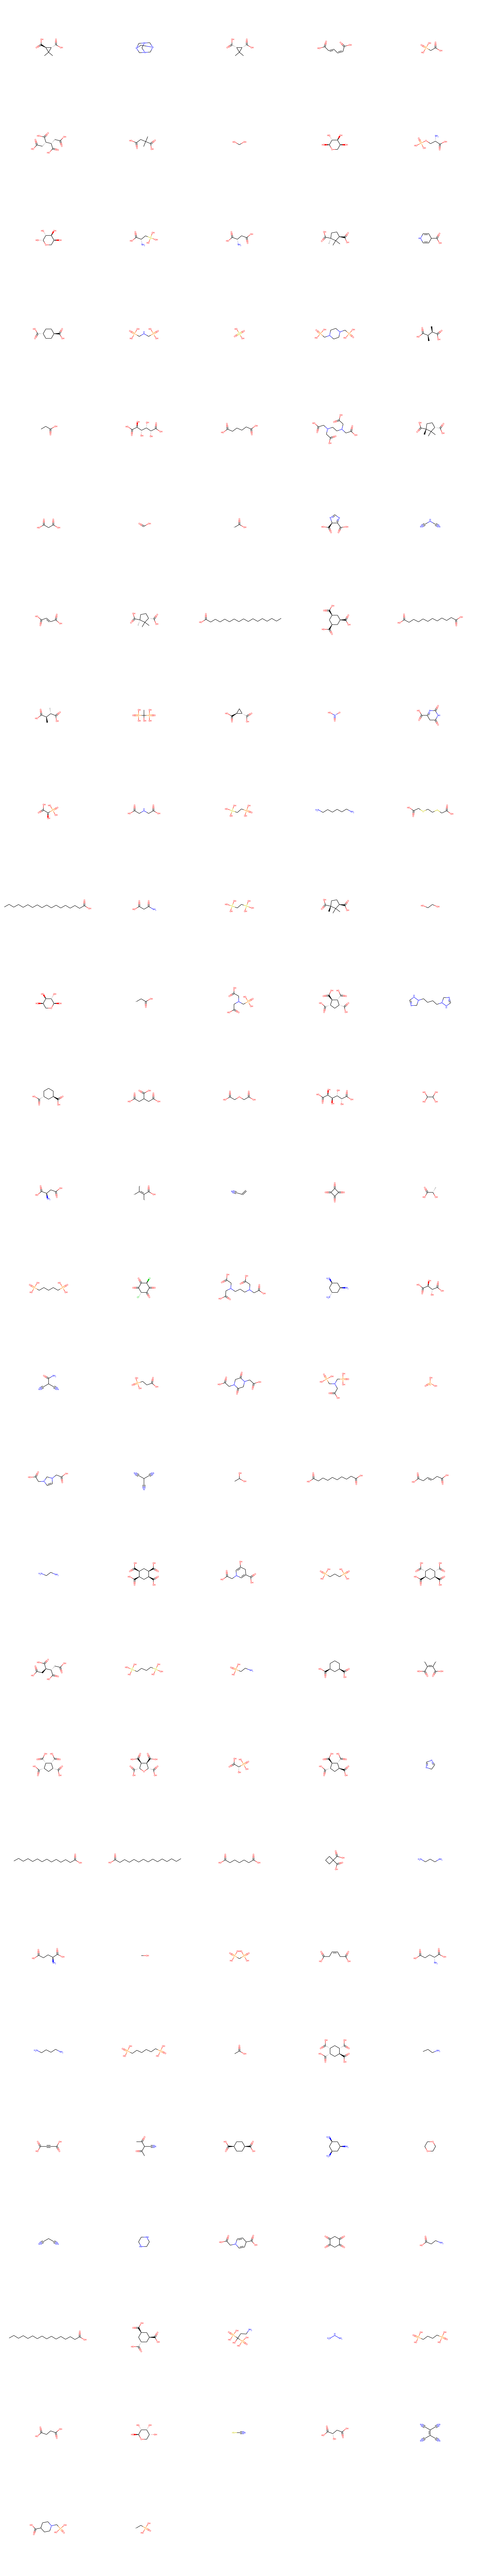

In [62]:
import pandas as pd
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

mols_list = []

for i in cluster_1_combination['linker_SMILES']:
    mols = Chem.MolFromSmiles(i)
    mols_list.append(mols)
    
mols_per_row = len(mols_list)  
Chem.Draw.MolsToGridImage(mols_list, molsPerRow=5, maxMols=200, subImgSize=(500, 500))

## Cluster VI: Rb

In [143]:
cluster_3 = np.where((embedding[:,0]<-1) & (embedding[:,0]>-2.5) & (embedding[:,1]<17) & (embedding[:,1]>15.5))
len(cluster_3[0])

475

In [144]:
cluster_3_combination = prediction_pd.iloc[cluster_3[0],:]
cluster_3_combination = cluster_3_combination.loc[cluster_3_combination['deepsvdd_predict']==1]
cluster_3_combination

metal                      linker_SMILES  deepsvdd  porosity  \
39574    Rb  CC1(C)[C@@H](C(=O)O)[C@@H]1C(=O)O  0.925949         0   
39577    Rb                 C1N2CN3CN1CN(C2)C3  0.960679         0   
39590    Rb   CC1(C)[C@@H](C(=O)O)[C@H]1C(=O)O  0.925949         0   
39592    Rb              O=C(O)/C=C\C=C\C(=O)O  0.958251         0   
39608    Rb                   O=C(O)CP(=O)(O)O  0.921046         0   
...     ...                                ...       ...       ...   
42407    Rb        NCCC(O)(P(=O)(O)O)P(=O)(O)O  0.924854         0   
42417    Rb                                NNN  0.939645         0   
42432    Rb             O=P(O)(O)CCCCP(=O)(O)O  0.955769         0   
42581    Rb         O=C(O)C1CCN(CP(=O)(O)O)CC1  0.937036         0   
42592    Rb                      [C]CP(=O)(O)O  0.938951         0   

       deepsvdd_predict  
39574                 1  
39577                 1  
39590                 1  
39592                 1  
39608                 1  
...                 ...  
42407                 1  
42417                 1  
42432                 1  
42581                 1  
42592                 1  

[119 rows x 5 columns]

In [145]:
metal_set_3 = set(cluster_3_combination['metal'].tolist())
len(metal_set_3)

1

In [146]:
linker_set_3 = set(cluster_3_combination['linker_SMILES'].tolist())
len(linker_set_3)

119

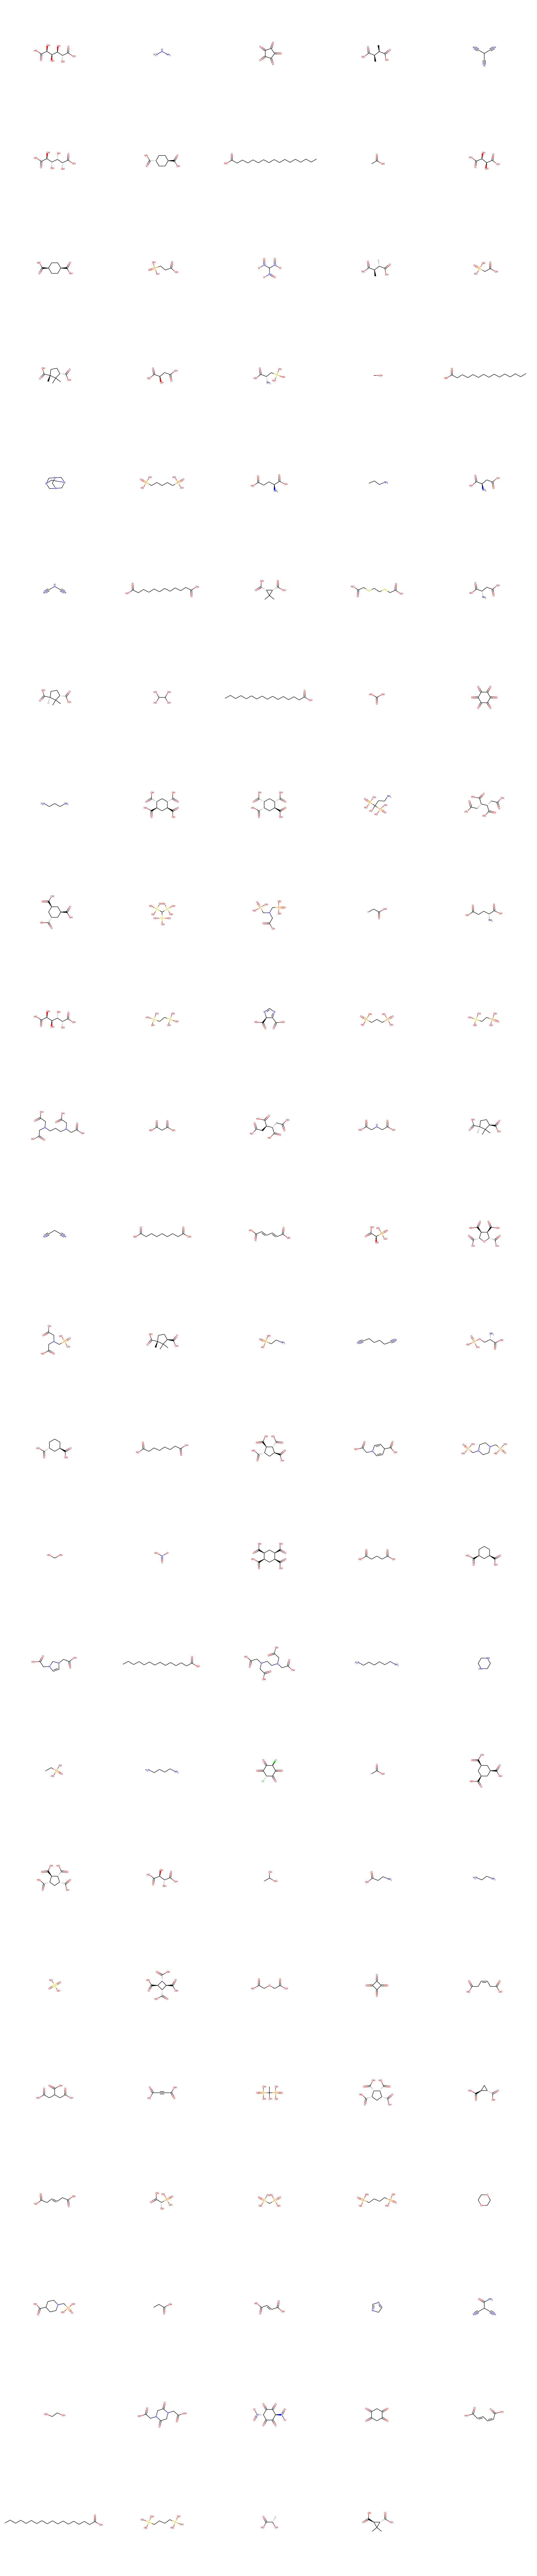

In [138]:
import pandas as pd
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

mols_list = []

for i in linker_set_3:
    mols = Chem.MolFromSmiles(i)
    mols_list.append(mols)
    
mols_per_row = len(mols_list)  
Chem.Draw.MolsToGridImage(mols_list, molsPerRow=5, maxMols=200, subImgSize=(500, 500))

## Cluster VII: Cs

In [140]:
cluster_4 = np.where((embedding[:,0]<25) & (embedding[:,0]>22.5) & (embedding[:,1]<11) & (embedding[:,1]>9.5))
len(cluster_4[0])

622

In [141]:
cluster_4_combination = prediction_pd.iloc[cluster_4[0],:]
cluster_4_combination = cluster_4_combination.loc[cluster_4_combination['deepsvdd_predict']==1]
cluster_4_combination

metal                      linker_SMILES  deepsvdd  porosity  \
119772    Cs                O=C(O)c1nsnc1C(=O)O  0.934909         0   
119784    Cs  CC1(C)[C@@H](C(=O)O)[C@@H]1C(=O)O  0.940746         0   
119787    Cs                 C1N2CN3CN1CN(C2)C3  0.947379         0   
119800    Cs   CC1(C)[C@@H](C(=O)O)[C@H]1C(=O)O  0.940746         0   
119802    Cs              O=C(O)/C=C\C=C\C(=O)O  0.957367         0   
...      ...                                ...       ...       ...   
122729    Cs           O=C(O)c1cc(C(=O)O)[nH]n1  0.965343         0   
122737    Cs                               N#CS  0.926510         0   
122760    Cs                N#CC(C#N)=C(C#N)C#N  0.938461         0   
122783    Cs         O=C(O)C1CCN(CP(=O)(O)O)CC1  0.929320         0   
122794    Cs                      [C]CP(=O)(O)O  0.935736         0   

        deepsvdd_predict  
119772                 1  
119784                 1  
119787                 1  
119800                 1  
119802                 1  
...                  ...  
122729                 1  
122737                 1  
122760                 1  
122783                 1  
122794                 1  

[143 rows x 5 columns]

In [151]:
porosity_set_4 = set(cluster_4_combination['porosity'].tolist())
len(porosity_set_4)

1

In [142]:
metal_set_4 = set(cluster_4_combination['metal'].tolist())
len(metal_set_4)

1

In [143]:
linker_set_4 = set(cluster_4_combination['linker_SMILES'].tolist())
len(linker_set_4)

143

In [153]:
#overlap with K (105),overlap with Rb (102), overlap with K, Rb(94), overlap with K, Rb and Ba(76)
a = [i for i in linker_set_4 if (i in linker_set_3 and i in linker_set_1 and i in linker_set_2)]
len(a)

76

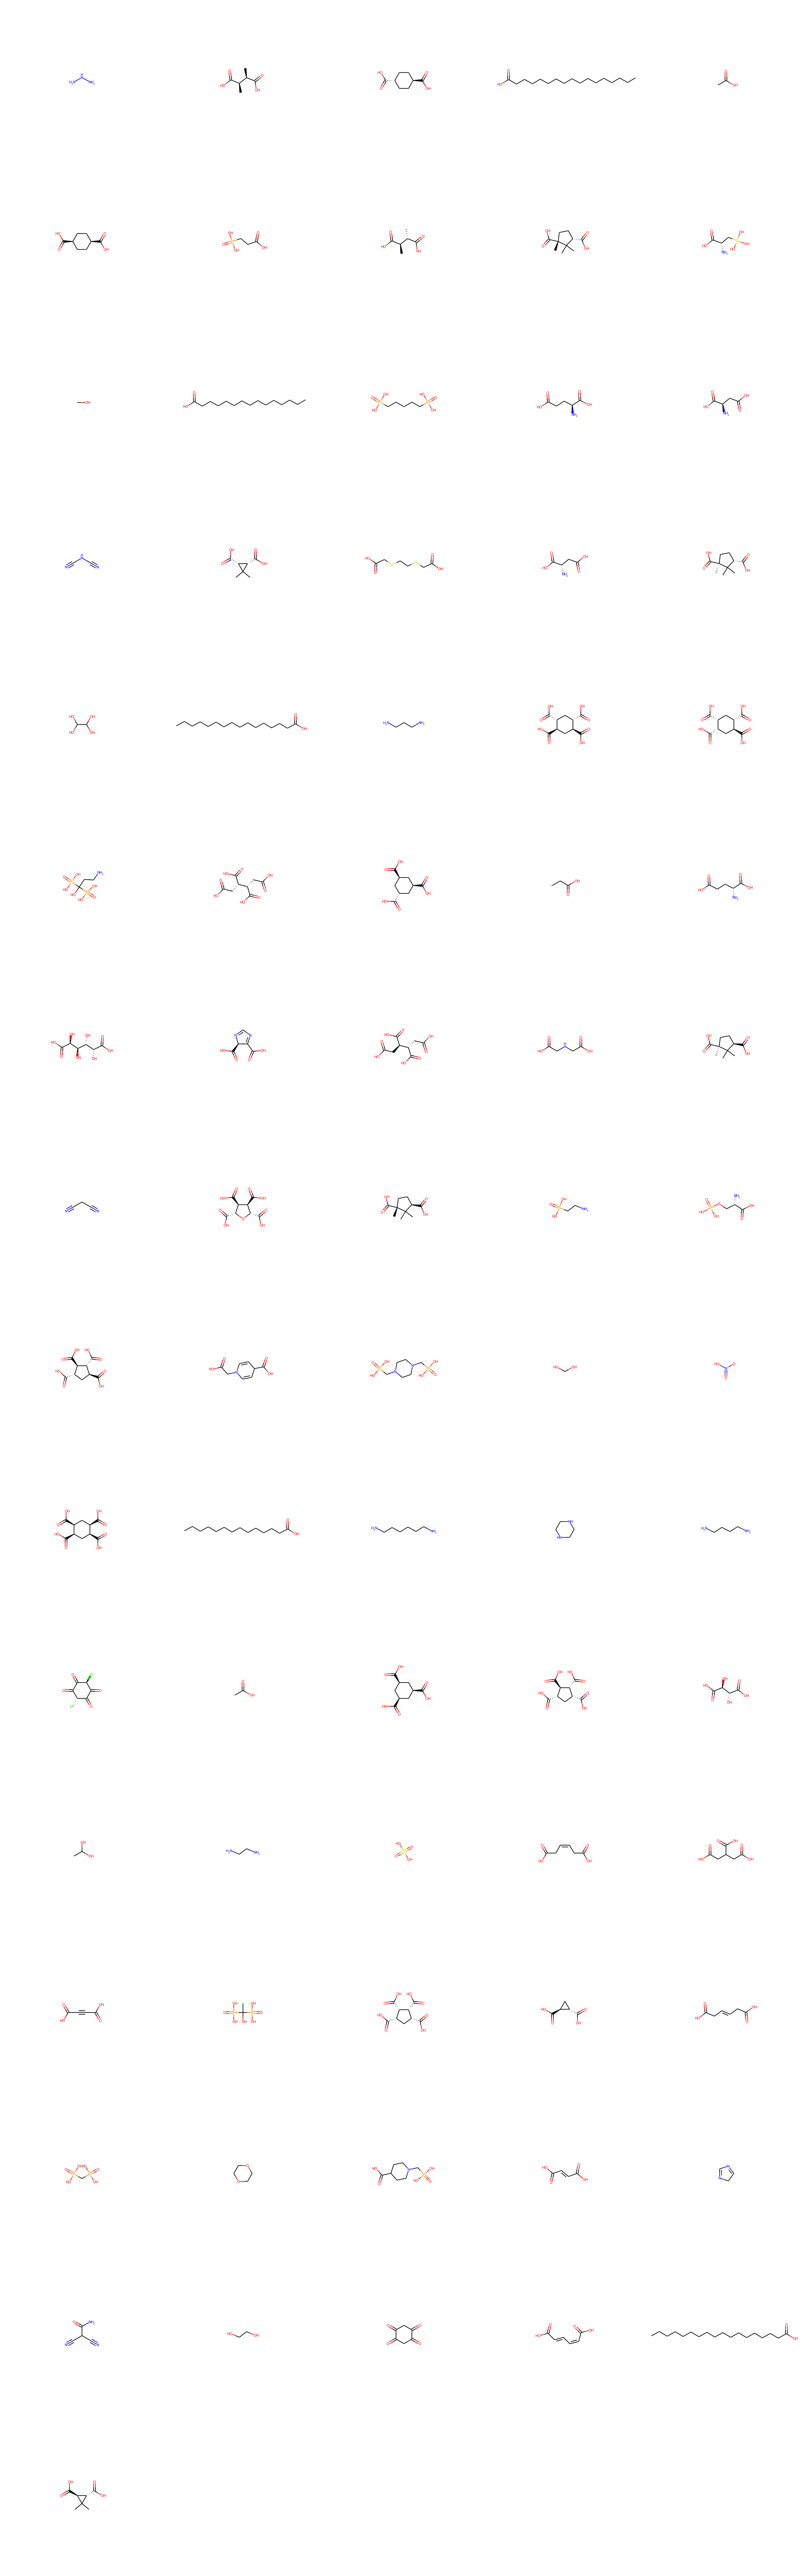

In [154]:
import pandas as pd
import rdkit
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

mols_list = []

for i in a:
    mols = Chem.MolFromSmiles(i)
    mols_list.append(mols)
    
mols_per_row = len(mols_list)  
Chem.Draw.MolsToGridImage(mols_list, molsPerRow=5, maxMols=200, subImgSize=(500, 500))

## Cluster VIII

In [258]:
cluster_4 = np.where((embedding[:,0]<14.7) & (embedding[:,0]>13.2) & (embedding[:,1]<-1) & (embedding[:,1]>-1.5))
len(cluster_4[0])

87

In [259]:
cluster_4_combination = prediction_pd.iloc[cluster_4[0],:]
#cluster_4_combination = cluster_4_combination.loc[cluster_4_combination['deepsvdd_predict']==1]
cluster_4_combination

metal                                      linker_SMILES  deepsvdd  \
38        Co     c1ccc2nc3c(nc2c1)c1nc2ccccc2nc1c1nc2ccccc2nc31  0.833019   
2393      Co  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1ccncc1)C(=O)N(c...  0.890464   
5177      Ag  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1ccncc1)C(=O)N(c...  0.880171   
5517      Mn     c1ccc2nc3c(nc2c1)c1nc2ccccc2nc1c1nc2ccccc2nc31  0.847155   
7950      Mn  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1ccncc1)C(=O)N(c...  0.881100   
...      ...                                                ...       ...   
153911    Cr  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1ccncc1)C(=O)N(c...  0.776845   
154298    Ru     c1ccc2nc3c(nc2c1)c1nc2ccccc2nc1c1nc2ccccc2nc31  0.522388   
157077    Ru  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1ccncc1)C(=O)N(c...  0.492758   
157465     W     c1ccc2nc3c(nc2c1)c1nc2ccccc2nc1c1nc2ccccc2nc31  0.258733   
160245     W  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1ccncc1)C(=O)N(c...  0.293536   

        porosity  deepsvdd_predict  
38             1                 0  
2393           3                 0  
5177           3                 0  
5517           1                 0  
7950           3                 0  
...          ...               ...  
153911         3                 0  
154298         1                 0  
157077         3                 0  
157465         1                 0  
160245         3                 0  

[87 rows x 5 columns]

In [260]:
metal_set_4 = set(cluster_4_combination['metal'].tolist())
len(metal_set_4)

52

In [261]:
linker_set_4 = set(cluster_4_combination['linker_SMILES'].tolist())
len(linker_set_4)

2

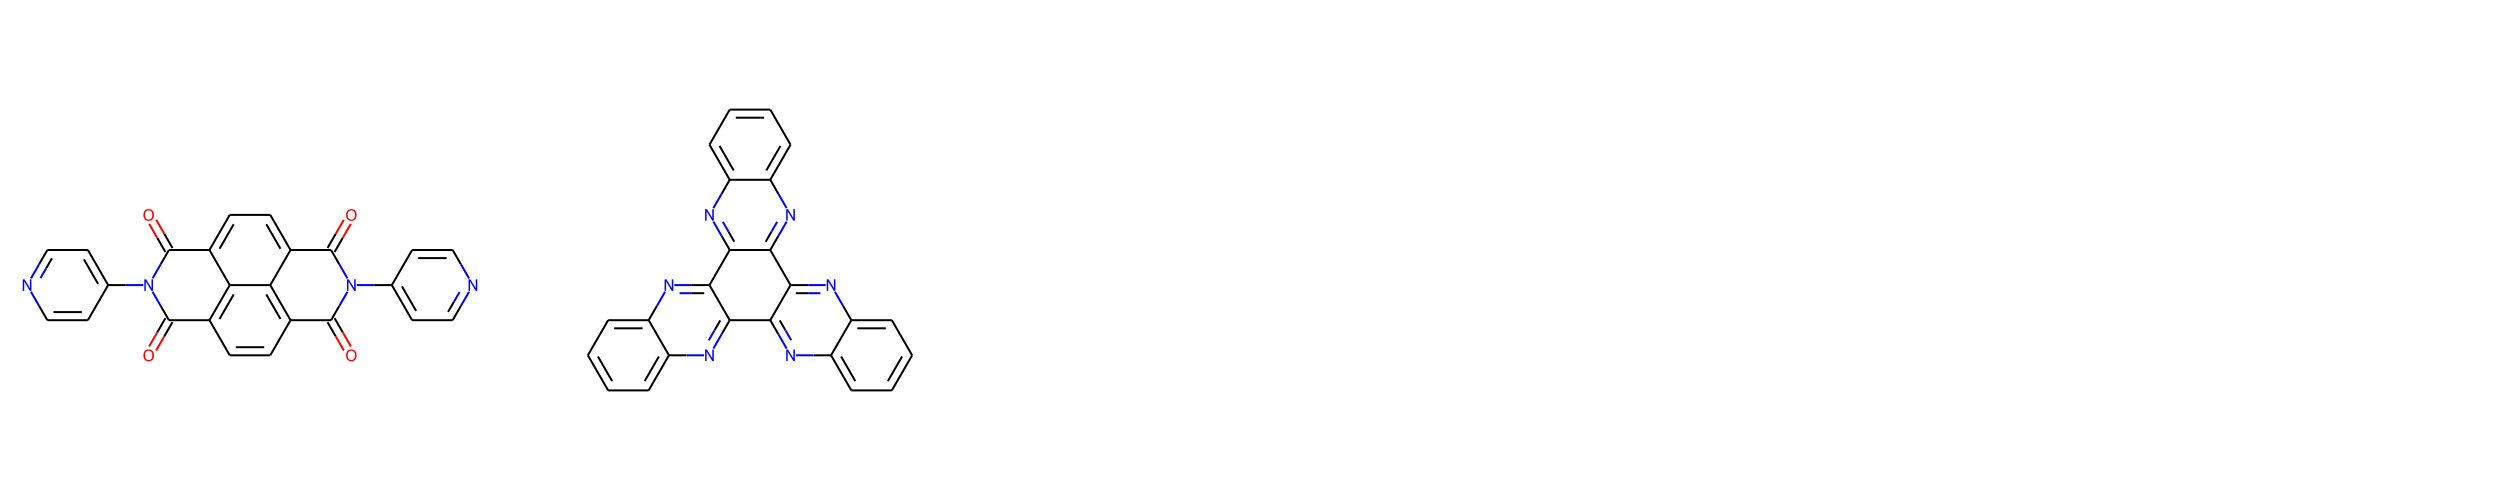

In [262]:
mols_list = []

for i in linker_set_4:
    mols = Chem.MolFromSmiles(i)
    mols_list.append(mols)
    
mols_per_row = len(mols_list)  
Chem.Draw.MolsToGridImage(mols_list, molsPerRow=5, maxMols=200, subImgSize=(500, 500))

## Cluster IX

In [152]:
cluster_4 = np.where((embedding[:,0]<14.7) & (embedding[:,0]>14) & (embedding[:,1]<0) & (embedding[:,1]>-1))
len(cluster_4[0])

52

In [153]:
cluster_4_combination = prediction_pd.iloc[cluster_4[0],:]
#cluster_4_combination = cluster_4_combination.loc[cluster_4_combination['deepsvdd_predict']==1]
cluster_4_combination

metal                                      linker_SMILES  deepsvdd  \
8491      Tb  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.807049   
9088      Tb  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.839774   
10426     Tb  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.791971   
21062     Pb  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.825845   
22115     La  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.794102   
22718     La  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.842822   
24064     La  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.740682   
25131     Eu  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.785431   
25720     Eu  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.840326   
27032     Eu  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.755360   
28088     Er  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.796894   
28698     Er  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.853023   
30070     Er  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.812310   
45946     Gd  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.799382   
46548     Gd  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.856610   
47895     Gd  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.792652   
48968     Dy  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.777007   
49575     Dy  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.849091   
50939     Dy  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.759935   
52005     Sm  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.780623   
52614     Sm  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.833968   
53991     Sm  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.731207   
58135     Nd  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.733056   
58741     Nd  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.812153   
60099     Nd  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.751285   
64165     Ho  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.794440   
64784     Ho  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.853586   
66171     Ho  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.775381   
67263     Pr  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.775193   
67868     Pr  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.836089   
69232     Pr  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.766279   
70316     Tm  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.780917   
70939     Tm  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.789945   
72342     Tm  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.717859   
87791     Bi  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.743135   
101309    Yb  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.783191   
101931    Yb  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.852607   
103319    Yb  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.765732   
106459    Hg  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.722461   
107559    Ba  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.774704   
108164    Ba  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.838393   
109515    Ba  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.766028   
112598     U  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.770407   
115740    Th  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.629556   
116854    Lu  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.722465   
117482    Lu  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.812199   
118889    Lu  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.672389   
128286    Tl  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.680382   
141889    Hf  O=C1c2ccc3c4c(ccc(c24)C(=O)N1c1nnn[nH]1)C(=O)N...  0.736105   
142514    Hf  Cc1n[nH]c(C)c1N1C(=O)c2ccc3c4c(ccc(c24)C1=O)C(...  0.806047   
143925    Hf  CC1(C)c2nc3cc4nn[nH]c4cc3nc2C(C)(C)c2nc3cc4[nH...  0.731388   
159

In [154]:
metal_set_4 = set(cluster_4_combination['metal'].tolist())
len(metal_set_4)

22

In [155]:
linker_set_4 = set(cluster_4_combination['linker_SMILES'].tolist())
len(linker_set_4)

3

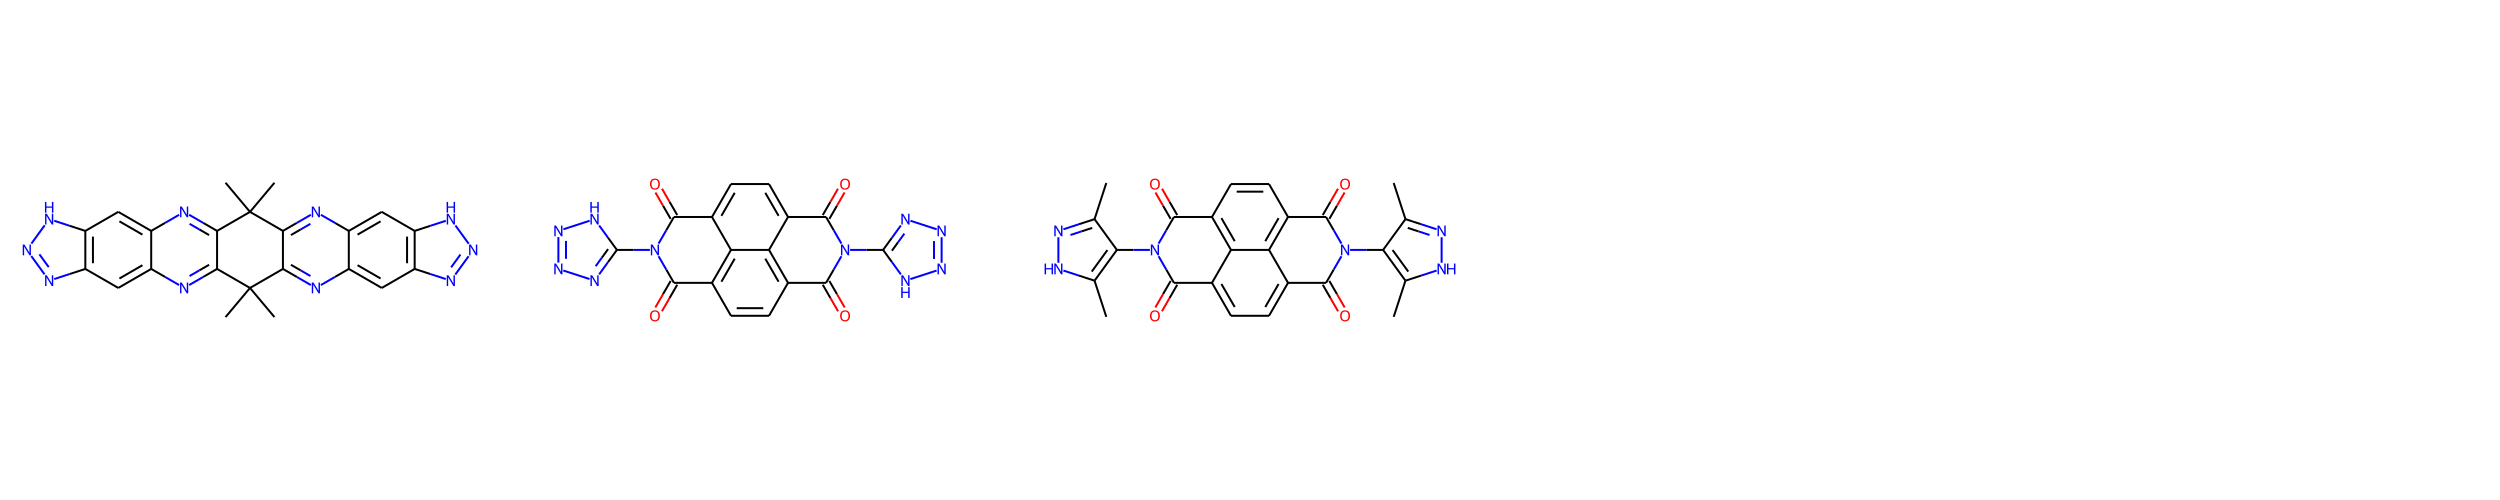

In [156]:
mols_list = []

for i in linker_set_4:
    mols = Chem.MolFromSmiles(i)
    mols_list.append(mols)
    
mols_per_row = len(mols_list)  
Chem.Draw.MolsToGridImage(mols_list, molsPerRow=5, maxMols=200, subImgSize=(500, 500))